In [1]:
pwd

'C:\\Users\\mc\\Desktop'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 사이킷런 클래스들
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression  # 이진 분류 모델

# 워닝 무시
import warnings
warnings.filterwarnings(action='ignore')

# 1. 데이터 로드 및 확인

In [7]:
# 피마 인디언 데이터 로드
diabetes_data = pd.read_csv('diabetes.csv')

# 데이터 확인
print(diabetes_data.shape)
diabetes_data.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


* Pregnancies: 임신 횟수
* Glucose: 포도당 부하 검사 수치
* BloodPressure: 혈압(mm Hg)
* SkinThickness: 팔 삼두근 뒤쪽의 피하지방 측정값(mm)
* Insulin: 혈청 인슐린(mu U/ml)
* BMI: 체질량지수(체중(kg)/(키(m))^2)
* DiabetesPedigreeFunction: 당뇨 내력 가중치 값
* Age: 나이
* Outcome: 클래스 결정 값(0또는 1)

In [8]:
# 클래스 분포 확인
print(diabetes_data['Outcome'].value_counts())

0    500
1    268
Name: Outcome, dtype: int64


In [9]:
diabetes_data.info( )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


# 2. 학습 및 예측 수행 : Logistic Regression

In [11]:
# 수정된 get_clf_eval() 함수
def get_clf_eval(y_test, pred=None, pred_proba=None):  # 평가지표들을 계산해줌
    confusion = confusion_matrix( y_test, pred)        # 오차 행렬
    accuracy = accuracy_score(y_test , pred)           # 정확도
    precision = precision_score(y_test , pred)         # 정밀도
    recall = recall_score(y_test , pred)               # 재현율
    f1 = f1_score(y_test,pred)                         # f1 score
    roc_auc = roc_auc_score(y_test, pred_proba)        # ROC AUC
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가    # '' 안에 {}가 있으면 문자열 포매팅이다  (.4f는 소수점 4째자리까지 보여줘라이다)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc), '\n')


In [12]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출. 
# 맨 끝이 Outcome 컬럼으로 레이블 값임. 컬럼 위치 -1을 이용해 추출 
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습
lr_clf = LogisticRegression()
lr_clf.fit(X_train , y_train)

# 예측
pred = lr_clf.predict(X_test)

# roc_auc_score 구하기 위한 분류 결정 예측 확률
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 평가지표들 구하기
get_clf_eval(y_test , pred, pred_proba)

오차 행렬
[[88 12]
 [23 31]]
정확도: 0.7727, 정밀도: 0.7209, 재현율: 0.5741,    F1: 0.6392, AUC:0.7919 



# 3. 모델 평가

**앞 예제에서 사용된 get_clf_eval()과 precision_recall_curve_plot() 재 로딩**

In [13]:
# 정밀도-재현율 trade-off 관계 그래프
def precision_recall_curve_plot(y_test=None, pred_proba_c1=None):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

### precision recall 곡선 그래프

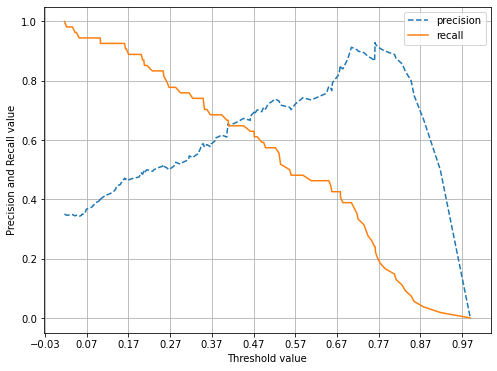

In [14]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]

precision_recall_curve_plot(y_test, pred_proba_c1)

**각 피처들의 값 4분위 분포 확인**

In [15]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


**'Glucose' 피처의 분포도**

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

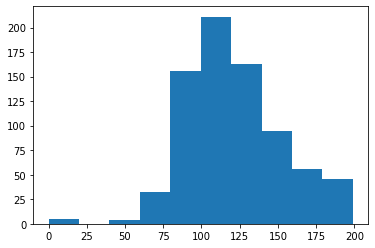

In [16]:
plt.hist(diabetes_data['Glucose'], bins=10)

### 0값이 있는 피처들에서 0값의 데이터 건수와 퍼센트 계산

In [24]:
# 0값을 검사할 피처명 리스트 객체 설정
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처 별 반복 하면서 값이 0 인 데이터 건수를 추출하고, 퍼센트도 계산해보자.
# 13s(문자열), 3d(정수)는 띄어쓰기로 프린트 정렬도와줌
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0:13s}    0 건수는 {1:3d}건, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose          0 건수는   0건, 퍼센트는 0.00 %
BloodPressure    0 건수는   0건, 퍼센트는 0.00 %
SkinThickness    0 건수는   0건, 퍼센트는 0.00 %
Insulin          0 건수는   0건, 퍼센트는 0.00 %
BMI              0 건수는   0건, 퍼센트는 0.00 %


### 0값을 평균값으로 대체

In [25]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체 (0값은 있어서는 안된다)
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, diabetes_data[zero_features].mean())

# 4. 데이터 전처리 후 다시 학습 및 모델 평가

### 데이터 전처리 : 피처 스케일링 적용

In [26]:
# feature와 target값 분리
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler( )
X_scaled = scaler.fit_transform(X)

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행. 
lr_clf = LogisticRegression()
lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)

# roc_auc_score 수정에 따른 추가
pred_proba = lr_clf.predict_proba(X_test)[:, 1]
get_clf_eval(y_test , pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,    F1: 0.6804, AUC:0.8433 



### 이번에는 분류 결정 임곗값을 변경하면서 성능을 측정해보자

In [27]:
from sklearn.preprocessing import Binarizer

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds 리스트 객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        # roc_auc_score 관련 수정
        get_clf_eval(y_test , custom_predict, pred_proba_c1)

In [28]:
thresholds = [0.3 , 0.33 ,0.36,0.39, 0.42 , 0.45 ,0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds )

임곗값: 0.3
오차 행렬
[[67 33]
 [11 43]]
정확도: 0.7143, 정밀도: 0.5658, 재현율: 0.7963,    F1: 0.6615, AUC:0.8433 

임곗값: 0.33
오차 행렬
[[72 28]
 [12 42]]
정확도: 0.7403, 정밀도: 0.6000, 재현율: 0.7778,    F1: 0.6774, AUC:0.8433 

임곗값: 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222,    F1: 0.6667, AUC:0.8433 

임곗값: 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037,    F1: 0.6667, AUC:0.8433 

임곗값: 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667,    F1: 0.6792, AUC:0.8433 

임곗값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667,    F1: 0.6857, AUC:0.8433 

임곗값: 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,    F1: 0.6931, AUC:0.8433 

임곗값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,    F1: 0.6804, AUC:0.8433 



In [29]:
# 임곗값를 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 컬럼값을 Binarizer변환. 
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1,1)) 

# roc_auc_score 관련 수정
get_clf_eval(y_test , pred_th_048, pred_proba[:, 1])

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,    F1: 0.6931, AUC:0.8433 

